In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import VGG16, MobileNetV2, EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential, layers
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

2024-12-03 10:44:58.112947: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 10:44:58.115152: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-03 10:44:58.119690: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-03 10:44:58.130132: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733219098.152356    6451 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733219098.15

In [2]:
# Chemin pour accéder aux docs
train_dir = "./101_food_data/foodbuddy_food101/images"

In [3]:
# Liste des catégories

categories = sorted(os.listdir(train_dir))
categories

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [4]:
# Création du dataframe

df = pd.DataFrame(columns=['image_path', 'label'])

dfs = []

for category in categories:
    category_path = os.path.join(train_dir, category)
    image_data = []
    for image_name in os.listdir(category_path):
        image_path = os.path.join(category_path, image_name)
        image_data.append({'image_path': image_path, 'label': category})
    df_category = pd.DataFrame(image_data)
    dfs.append(df_category)

df = pd.concat(dfs, ignore_index=True)
df

,image_path,label
0,./101_food_data/foodbuddy_food101/images/apple...,apple_pie
1,./101_food_data/foodbuddy_food101/images/apple...,apple_pie
2,./101_food_data/foodbuddy_food101/images/apple...,apple_pie
3,./101_food_data/foodbuddy_food101/images/apple...,apple_pie
4,./101_food_data/foodbuddy_food101/images/apple...,apple_pie
...,...,...
100995,./101_food_data/foodbuddy_food101/images/waffl...,waffles
100996,./101_food_data/foodbuddy_food101/images/waffl...,waffles
100997,./101_food_data/foodbuddy_food101/images/waffl...,waffles
100998,./101_food_data/foodbuddy_food101/images/waffl...,waffles


In [5]:
# Analyse des données

df['label'].value_counts()

label
apple_pie         1000
baby_back_ribs    1000
baklava           1000
beef_carpaccio    1000
beef_tartare      1000
                  ... 
tacos             1000
takoyaki          1000
tiramisu          1000
tuna_tartare      1000
waffles           1000
Name: count, Length: 101, dtype: int64

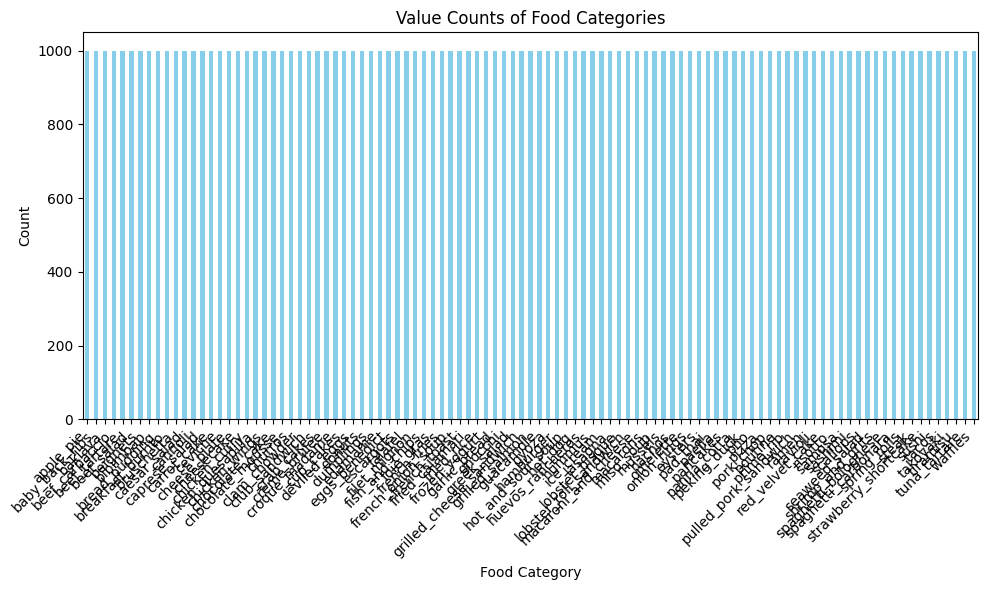

In [6]:
# Analyse des données bis

plt.figure(figsize=(10, 6))

df['label'].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Food Category')
plt.ylabel('Count')
plt.title('Value Counts of Food Categories')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [7]:
df['label'].value_counts()

label
apple_pie         1000
baby_back_ribs    1000
baklava           1000
beef_carpaccio    1000
beef_tartare      1000
                  ... 
tacos             1000
takoyaki          1000
tiramisu          1000
tuna_tartare      1000
waffles           1000
Name: count, Length: 101, dtype: int64

In [8]:
# Class weights

labels = df['label']

In [9]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)

In [10]:
class_weights_dict = dict(enumerate(class_weights))

In [11]:
print("Class Weights:", class_weights_dict)

Class Weights: {0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0), 3: np.float64(1.0), 4: np.float64(1.0), 5: np.float64(1.0), 6: np.float64(1.0), 7: np.float64(1.0), 8: np.float64(1.0), 9: np.float64(1.0), 10: np.float64(1.0), 11: np.float64(1.0), 12: np.float64(1.0), 13: np.float64(1.0), 14: np.float64(1.0), 15: np.float64(1.0), 16: np.float64(1.0), 17: np.float64(1.0), 18: np.float64(1.0), 19: np.float64(1.0), 20: np.float64(1.0), 21: np.float64(1.0), 22: np.float64(1.0), 23: np.float64(1.0), 24: np.float64(1.0), 25: np.float64(1.0), 26: np.float64(1.0), 27: np.float64(1.0), 28: np.float64(1.0), 29: np.float64(1.0), 30: np.float64(1.0), 31: np.float64(1.0), 32: np.float64(1.0), 33: np.float64(1.0), 34: np.float64(1.0), 35: np.float64(1.0), 36: np.float64(1.0), 37: np.float64(1.0), 38: np.float64(1.0), 39: np.float64(1.0), 40: np.float64(1.0), 41: np.float64(1.0), 42: np.float64(1.0), 43: np.float64(1.0), 44: np.float64(1.0), 45: np.float64(1.0), 46: np.float64(1.0), 47: np.

In [12]:
# On vérifie que toutes les classes ont le même poids
class_weights

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [13]:
# train test split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [14]:
train_df.shape

(80800, 2)

In [15]:
val_df.shape

(20200, 2)

In [16]:
# Image augmentation

augmentation_params = {
    'rotation_range': 20,
    'width_shift_range': 0.1,
    'height_shift_range': 0.1,
    'shear_range': 0.2,
    'zoom_range': 0.1,
    'horizontal_flip': True,
    'fill_mode': 'nearest'
}

In [17]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    **augmentation_params
)

In [18]:
img_size = (224, 224)

In [19]:
batch_size = 32

In [20]:
val_datagen = ImageDataGenerator(
    rescale = 1./255
    )

In [21]:
train_images = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='label',

    target_size=img_size,
    batch_size=batch_size,

    shuffle=True,
    seed=42,
    class_mode='categorical'
)

Found 80800 validated image filenames belonging to 101 classes.


In [22]:
val_images = val_datagen.flow_from_dataframe(
    val_df,
    x_col='image_path',
    y_col='label',

    target_size=img_size,
    batch_size=batch_size,

    shuffle=False,
    seed=42,
    class_mode='categorical'
)

Found 20200 validated image filenames belonging to 101 classes.


IndexError: index 24 is out of bounds for axis 0 with size 24

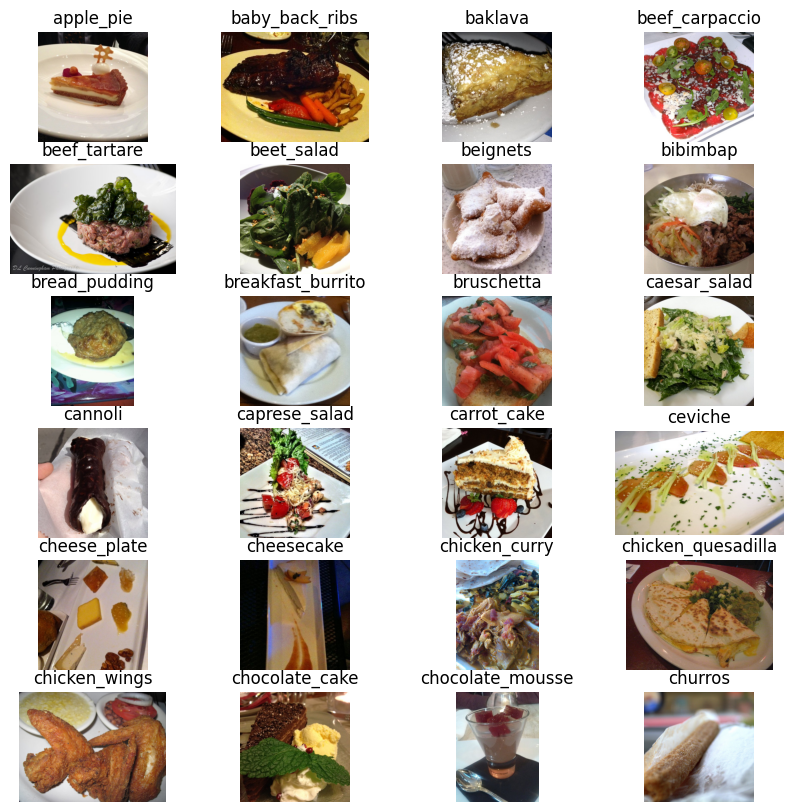

In [23]:
# Visualization of images

fig, axes = plt.subplots(6, 4, figsize=(10, 10))
axes = axes.flatten()

for i, category in enumerate(categories):
    category_df = train_df[train_df['label'] == category]
    image_path = category_df.iloc[100]['image_path']
    img = plt.imread(image_path)
    axes[i].imshow(img)
    axes[i].set_title(category)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

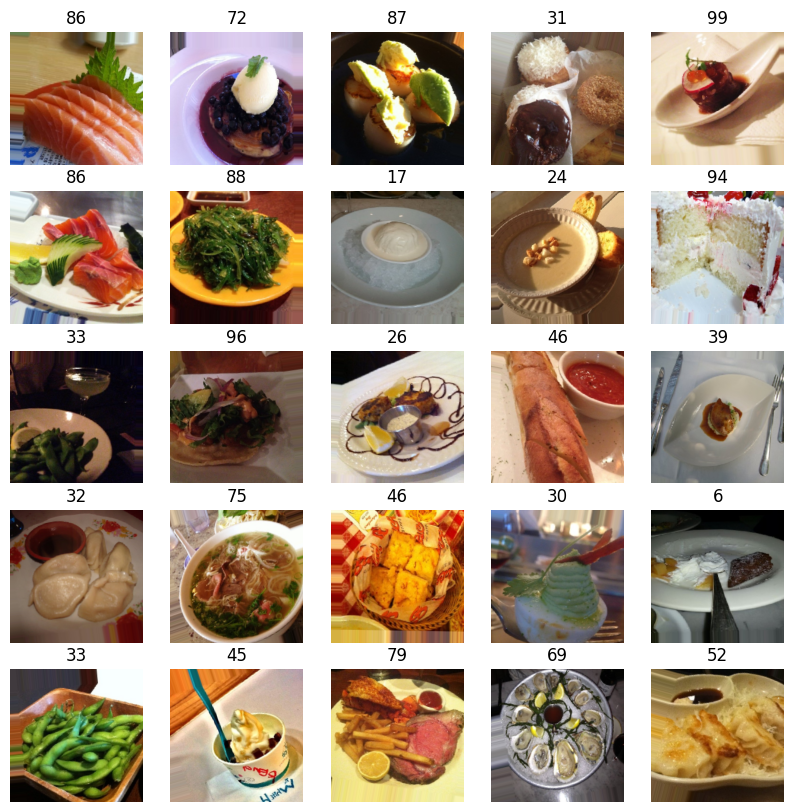

In [24]:
# Encoding classes names

batch_train_images, batch_train_labels = next(train_images)

class_names = np.argmax(batch_train_labels, axis=1)

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(batch_train_images[i])
    plt.title(class_names[i])
    plt.axis('off')
plt.show()

In [25]:
# Modèle MobileNet

pretrained_model = MobileNetV2(
    input_shape=(img_size[0], img_size[1], 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

# x = Dense(32, activation='relu')(pretrained_model.output)
# x = Dense(16, activation='relu')(x)
outputs = Dense(len(categories), activation='softmax')(pretrained_model.output)

model_mn = Model(pretrained_model.input, outputs, name='MobileNetV2')

print(model_mn.summary())

2024-12-03 10:45:20.269639: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "MobileNetV2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,387,365 (9.11 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

None


In [26]:
# Compiler le modèle

model_mn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [ ]:
# Entrainer le modèle avec l'accuracy

history_mn = model_mn.fit(
    train_images,
    validation_data=val_images,
    epochs=5,
    callbacks=[
        EarlyStopping(
            monitor='accuracy',
            patience=5,
            restore_best_weights=True
        )
    ]
)

/home/victor/.pyenv/versions/3.10.6/envs/foodbuddy/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
1820/2525 ━━━━━━━━━━━━━━━━━━━━ 6:56 590ms/step - accuracy: 0.3421 - loss: 2.8055

In [ ]:
# Sauvegarde intermédiaire avec ModelCheckpoint
checkpoint_callback = ModelCheckpoint(
    filepath='./101_food_data/model_checkpoint.keras',  # Nom de fichier pour la sauvegarde
    save_best_only=True,             # Sauvegarde uniquement le meilleur modèle
    save_weights_only=False,         # Sauvegarde le modèle complet (architecture + poids)
    monitor='val_loss',              # Critère de surveillance
    mode='min',                      # Mode minimisation pour val_loss
    verbose=1                        # Affichage des logs
)

# Early stopping
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)


In [ ]:
# Entraînement avec les callbacks
history_mn = model_mn.fit(
    train_images,
    validation_data=val_images,
    epochs=1,
    callbacks=[
        early_stopping_callback,
        checkpoint_callback  # Ajout du callback pour la sauvegarde
    ]
)

NameError: name 'model_mn' is not defined

In [ ]:
# Save le modèle
model_mn.save('./RNN/MobileNet_Food101.h5')

NameError: name 'model_mn' is not defined

In [ ]:
val_loss_mn, val_acc_mn = model_mn.evaluate(val_images, verbose=0)

In [ ]:
val_loss_mn

1.9750078916549683

In [ ]:
val_acc_mn

0.5432673096656799

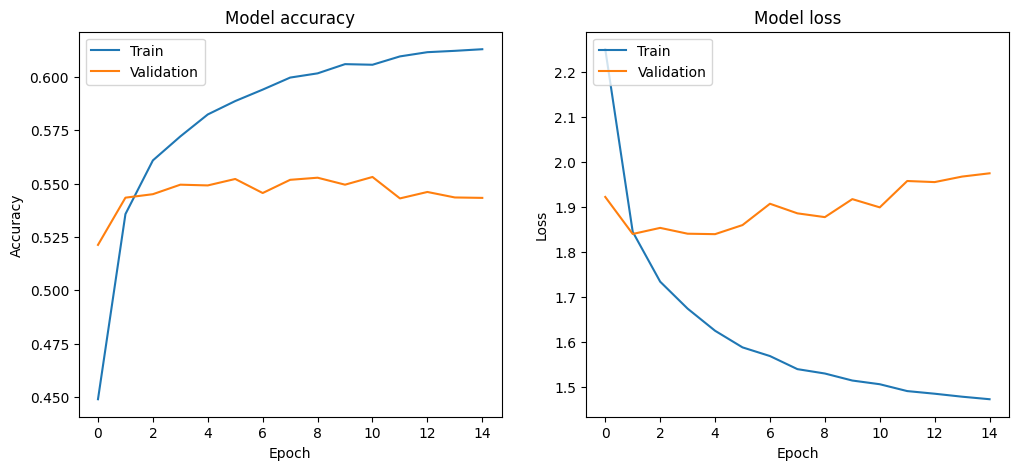

In [ ]:
# Comparaison des accuracy et loss des données val et train

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_mn.history['accuracy'])
plt.plot(history_mn.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_mn.history['loss'])
plt.plot(history_mn.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
predictions = model_mn.predict(val_images)
predicted_classes = np.argmax(predictions, axis=1)

predicted_classes

632/632 ━━━━━━━━━━━━━━━━━━━━ 220s 345ms/step


array([92, 52, 45, ..., 19, 30, 33])

In [ ]:
true_classes = val_images.classes

In [ ]:
class_labels = list(val_images.class_indices.keys())

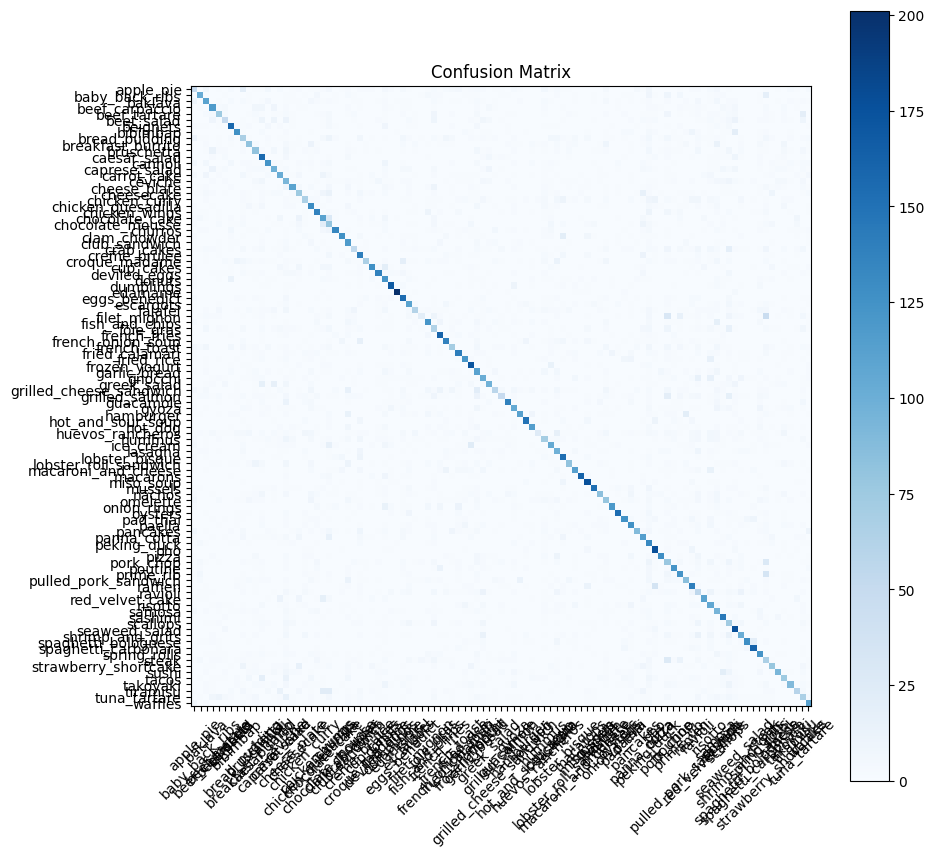

In [ ]:
# Confusion matrix

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

plt.show()

In [ ]:
# KPIs finaux

report = classification_report(true_classes, predicted_classes, target_names=class_labels)

print(report)

                         precision    recall  f1-score   support

              apple_pie       0.28      0.24      0.26       205
         baby_back_ribs       0.65      0.54      0.59       188
                baklava       0.51      0.52      0.51       212
         beef_carpaccio       0.58      0.58      0.58       201
           beef_tartare       0.51      0.40      0.45       186
             beet_salad       0.49      0.27      0.35       183
               beignets       0.67      0.72      0.70       218
               bibimbap       0.75      0.64      0.69       196
          bread_pudding       0.31      0.31      0.31       217
      breakfast_burrito       0.54      0.42      0.47       194
             bruschetta       0.46      0.42      0.44       194
           caesar_salad       0.47      0.73      0.57       214
                cannoli       0.65      0.58      0.61       214
          caprese_salad       0.54      0.49      0.51       202
            carrot_cake 